In [15]:
CONFIG_FILE = "model/model_v_0_5_config.py"

In [16]:
import importlib
import numpy as np
import pandas as pd
import json
# from src.custom_types import Metadata
from typing import Any
from keras import models, losses, metrics
from src.helpers import load_metadata, load_preprocessed_data, standardize

config = importlib.import_module(CONFIG_FILE.replace("/", ".").replace(".py", ""))
importlib.reload(config)

<module 'model.model_v_0_5_config' from '/Users/michaelbonon/Coding/stock-price-prediction/model/model_v_0_5_config.py'>

In [17]:
# Check if config file has all the required attributes
print(dir(config))

required_attributes = [
    "VERSION_MAJOR",
    "VERSION_MINOR",
    "DATA_DIR",
    "DATA_FILENAME_MAP",
    "TEST_SET",
    "MODELS_DIR",
    "GET_INDEX_X_Y",
    "TRAINING_SET_PREPROCESSING",
    "LOSS_FUNCTION",
    "METRICS",
]

for attr in required_attributes:
    if not hasattr(config, attr):
        raise ValueError(f"Missing attribute {attr} in config file.")
    
VERSION_MAJOR = config.VERSION_MAJOR
VERSION_MINOR = config.VERSION_MINOR
DATA_DIR = config.DATA_DIR
DATA_FILENAME_MAP = config.DATA_FILENAME_MAP
TEST_SET = config.TEST_SET
MODELS_DIR = config.MODELS_DIR
GET_INDEX_X_Y = config.GET_INDEX_X_Y
TRAINING_SET_PREPROCESSING = config.TRAINING_SET_PREPROCESSING
LOSS_FUNCTION = config.LOSS_FUNCTION
METRICS = config.METRICS

['BASELINE_MODEL_FILENAME', 'DATA_DIR', 'DATA_FILENAME_MAP', 'GET_INDEX_X_Y', 'LEARNING_RATE', 'LOAD_BASELINE_MODEL', 'LOSS_FUNCTION', 'MAX_EPOCHS', 'METRICS', 'MODELS_DIR', 'Metadata', 'PATIENCE', 'TEST_SET', 'TRAINING_SET', 'TRAINING_SET_PREPROCESSING', 'VALIDATION_SET', 'VERSION_MAJOR', 'VERSION_MINOR', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'df_windowed_to_index_x_y', 'pd']


In [18]:
loaded_dataset = {}

for item in TEST_SET:
    filename = DATA_FILENAME_MAP[item]["filename"]
    metadata_filename = DATA_FILENAME_MAP[item]["metadata"]

    metadata = load_metadata(DATA_DIR, metadata_filename)
    df = load_preprocessed_data(DATA_DIR, filename, metadata)
    
    index_data, feature_data, target_data = GET_INDEX_X_Y(df, metadata)

    model_output_params_filepath = "{}/v_{}_{}/{}".format(
        MODELS_DIR,
        VERSION_MAJOR,
        VERSION_MINOR,
        "model_output_params.json"
        )
    with open(model_output_params_filepath) as f:
        model_output_params = json.load(f)
    
    for feature_name, preprocessing_steps in TRAINING_SET_PREPROCESSING:
        if feature_name not in metadata["features"]:
            raise ValueError(f"Feature {feature_name} not found in metadata.")

        feature_index = metadata["features"].index(feature_name)
        for preprocessing_step in preprocessing_steps:
            if preprocessing_step == "z-score":
                training_mean = np.float32(model_output_params[f"{feature_name}_mean"])
                training_std = np.float32(model_output_params[f"{feature_name}_std"])    
                feature_data = standardize(feature_data, feature_index, training_mean, training_std)
            else:
                raise ValueError(f"Preprocessing step {preprocessing_step} not supported.")

    loaded_dataset[item] = {
        "index": index_data,
        "x": feature_data,
        "y": target_data,
    }

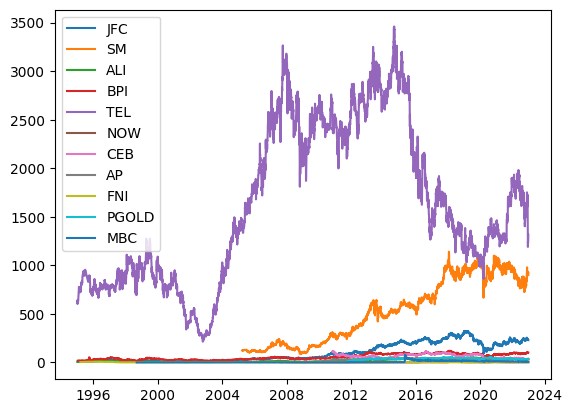

In [19]:
import matplotlib.pyplot as plt

for item in TEST_SET:
    dates = loaded_dataset[item]["index"]
    y = loaded_dataset[item]["y"]
    plt.plot(dates, y)

plt.legend(TEST_SET)

 14/212 [>.............................] - ETA: 0s  

2023-03-12 22:43:51.082836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 22:43:51.140817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


212/212 [==============================] - 1s 4ms/step


2023-03-12 22:43:52.255034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-12 22:43:52.307577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


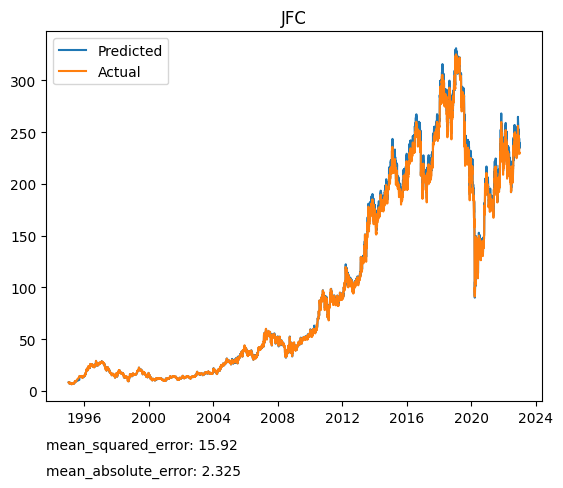

['loss', 'mean_absolute_error'] [15.92, 2.325]
136/136 [==============================] - 1s 4ms/step


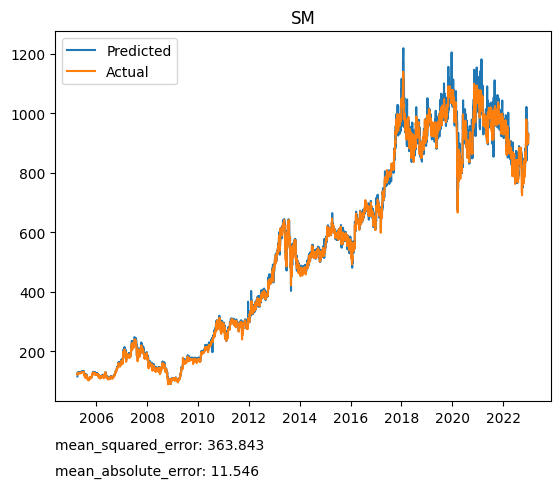

['loss', 'mean_absolute_error'] [363.843, 11.546]
212/212 [==============================] - 1s 4ms/step


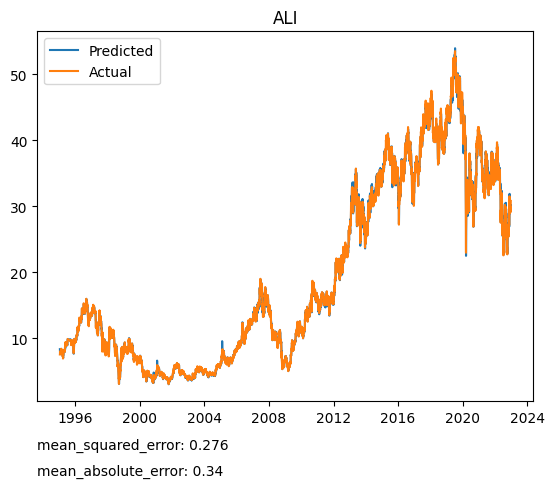

['loss', 'mean_absolute_error'] [0.276, 0.34]
211/211 [==============================] - 1s 4ms/step


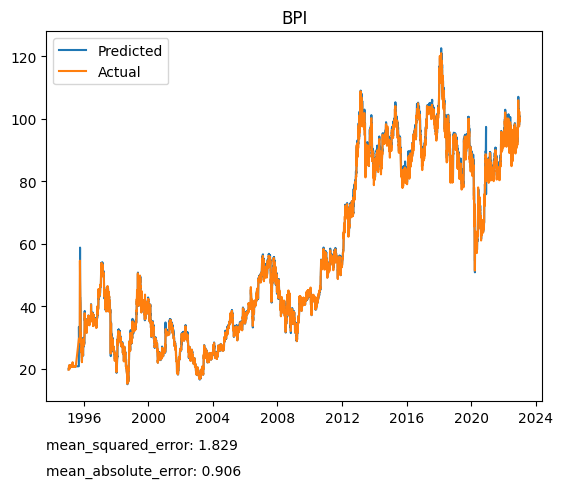

['loss', 'mean_absolute_error'] [1.829, 0.906]
212/212 [==============================] - 1s 4ms/step


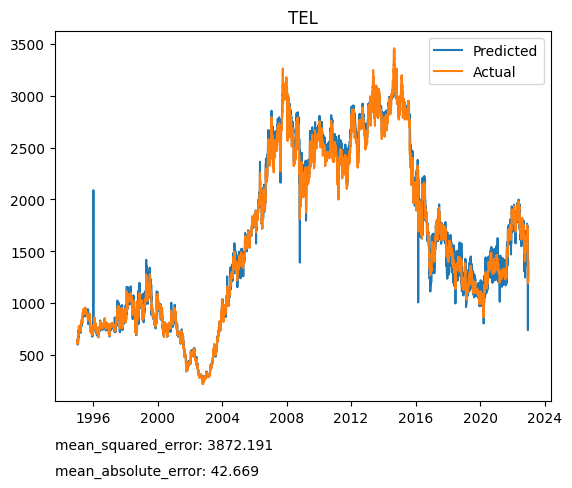

['loss', 'mean_absolute_error'] [3872.191, 42.669]
95/95 [==============================] - 0s 4ms/step


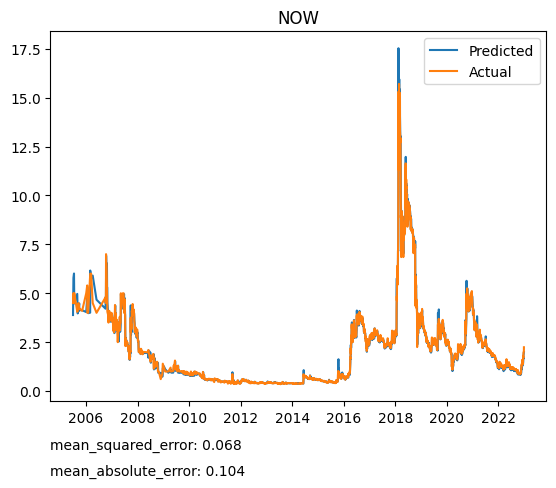

['loss', 'mean_absolute_error'] [0.068, 0.104]
93/93 [==============================] - 0s 5ms/step


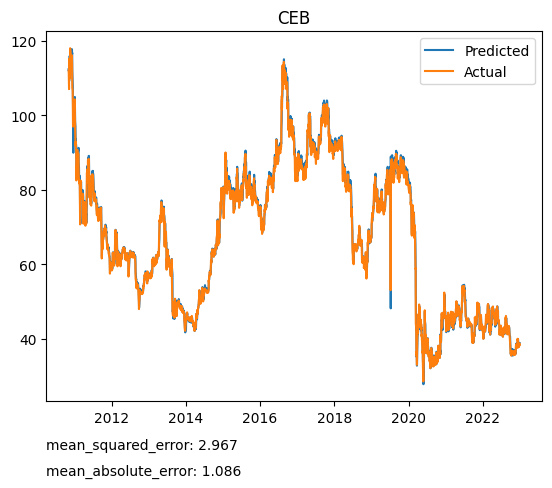

['loss', 'mean_absolute_error'] [2.967, 1.086]
118/118 [==============================] - 0s 4ms/step


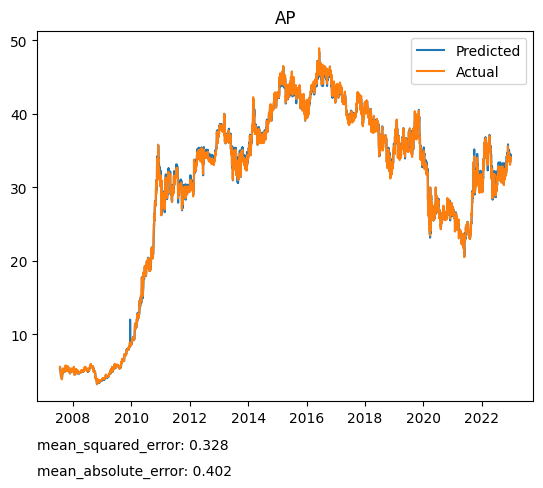

['loss', 'mean_absolute_error'] [0.328, 0.402]
181/181 [==============================] - 1s 4ms/step


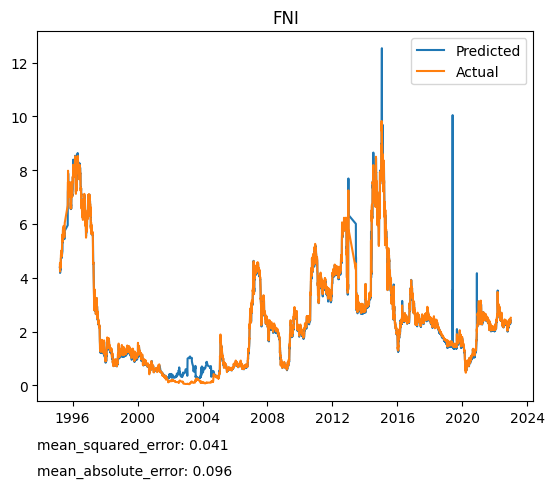

['loss', 'mean_absolute_error'] [0.041, 0.096]
86/86 [==============================] - 0s 4ms/step


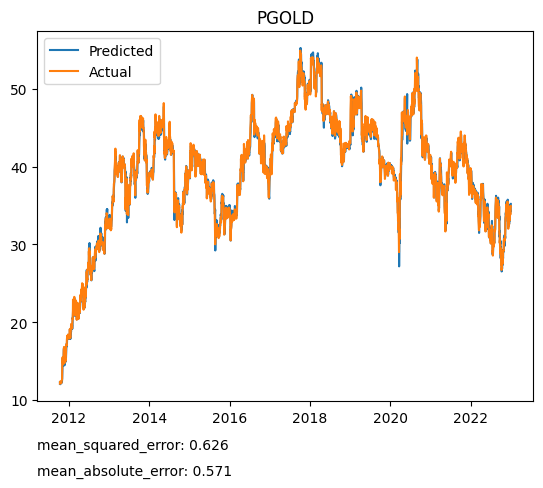

['loss', 'mean_absolute_error'] [0.626, 0.571]
33/33 [==============================] - 0s 5ms/step


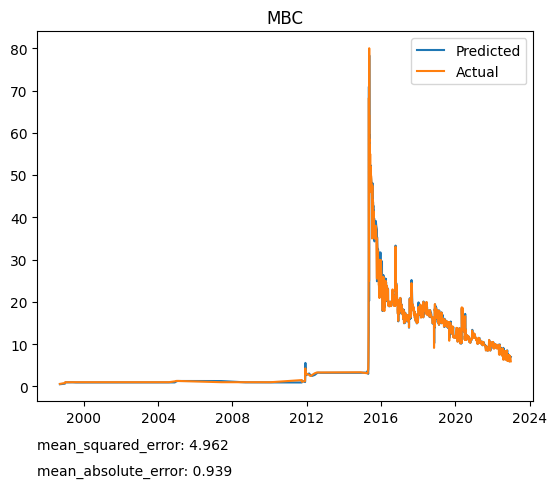

['loss', 'mean_absolute_error'] [4.962, 0.939]


In [20]:
model_filepath = "{}/v_{}_{}/{}".format(
  MODELS_DIR,
  VERSION_MAJOR,
  VERSION_MINOR,
  "model.h5"
)
model: Any = models.load_model(model_filepath)

test_results = {}

for item in TEST_SET:
    dates = loaded_dataset[item]["index"]
    x = loaded_dataset[item]["x"]
    y = loaded_dataset[item]["y"]
    y_pred = model.predict(x)

    plt.figure()
    plt.plot(dates, y_pred)
    plt.plot(dates, y)
    plt.legend(["Predicted", "Actual"])
    plt.title(item)
  

    results = model.evaluate(x, y, verbose=0)
    # round-off results to 3 decimal places
    results = [round(result, 3) for result in results]
    
    for i, result in enumerate(results):
        metric_name = model.metrics_names[i]
        if metric_name == "loss":
            metric_name = LOSS_FUNCTION
        plt.text(0, -0.1 - i * 0.07, f"{metric_name}: {result}", 
            transform=plt.gca().transAxes,
            verticalalignment='top',
            horizontalalignment='left', 
        )
    plt.show()

    test_results[item] = {}
    test_results[item] = results

    print(model.metrics_names, results)

In [21]:
print("Summary:")
print(f"Stock: {model.metrics_names}")
for item in test_results:
    print(f"{item}: {test_results[item]}")

Summary:
Stock: ['loss', 'mean_absolute_error']
JFC: [15.92, 2.325]
SM: [363.843, 11.546]
ALI: [0.276, 0.34]
BPI: [1.829, 0.906]
TEL: [3872.191, 42.669]
NOW: [0.068, 0.104]
CEB: [2.967, 1.086]
AP: [0.328, 0.402]
FNI: [0.041, 0.096]
PGOLD: [0.626, 0.571]
MBC: [4.962, 0.939]
